# Approach 2

Getting back into it after some time with a new approach for finding patterns. Initial exploration and analysis.

### Init

In [3]:
import polars as pl
from polars import selectors as cs
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm
import numpy as np
import scipy as sp
import seaborn as sns


In [4]:
DEBUG = False
WINDOW_SIZE = 10


### Load and unpivot

In [5]:
path = os.path.join('data', 'silver', 'prices_with_nrdy')

df = pl.read_parquet(path)

In [6]:
display(df)

date,ticker,price
date,str,f64
1994-03-18,"""SCSC""",1.71875
1994-03-21,"""SCSC""",1.90625
1994-03-22,"""SCSC""",1.9375
1994-03-23,"""SCSC""",2.09375
1994-03-24,"""SCSC""",2.09375
…,…,…
2024-04-26,"""NRDY""",2.76
2024-04-29,"""NRDY""",2.71
2024-04-30,"""NRDY""",2.59


### Plot price over time

In [7]:
def plot_price(df, ticker=None, x='date', y='price'):
    if not ticker:
        ticker = ''

    dates = df[x]
    prices = df[y]

    fig, ax = plt.subplots()
    ax.plot(dates, prices)
    # ax.scatter(dates, prices, s=5)
    plt.title(ticker)
    plt.show()
    

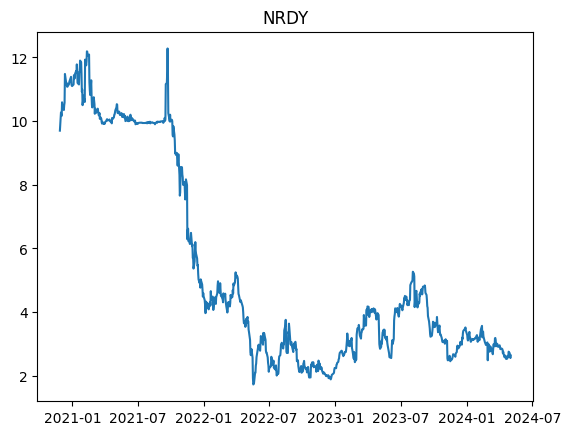

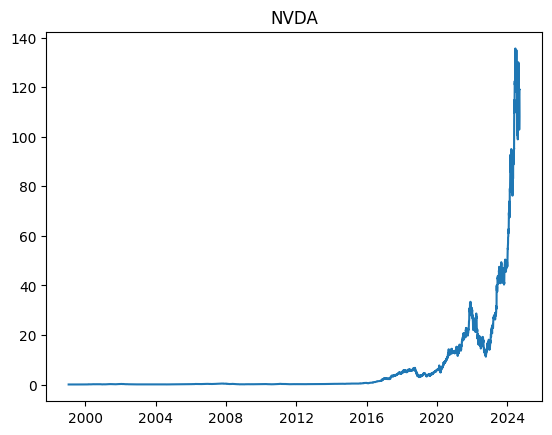

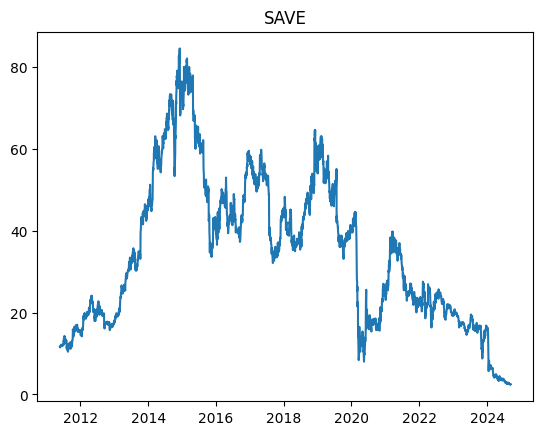

In [8]:
test_tickers = ['NRDY', 'NVDA', 'SAVE']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

for ticker, group_df in filtered_df.group_by('ticker'):
    plot_price(group_df, ticker[0])



### Detrending

In [9]:
def plot_detrended(ticker, actuals, predictions, adjusted):
    x = list(range(0, len(actuals)))

    fig, ax = plt.subplots()
    ax.scatter(x, actuals, s=5)
    ax.plot(x, predictions)
    ax.plot(x, adjusted)
    ax.set_title(ticker)
    plt.xticks(rotation=45)
    plt.show()

In [10]:
def detrend_lin_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    ticker = df['ticker'][0]

    df = df.sort(pl.col('date'))

    rows, cols = df.shape

    # create X and y
    X = list(range(0, rows))
    X = sm.add_constant(X)
    y = df['price'].to_numpy()

    # fit model
    model = sm.OLS(y, X)
    results = model.fit()

    # make predictions
    predictions = results.predict()

    # detrend using model predictions
    df = df.with_columns(pl.col('price') - predictions)

    if DEBUG:
        print(results.summary())

        plot_detrended(ticker, y, predictions, df['price'])
    
    return df



In [11]:
def detrend_exp_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns

    df = df.with_columns(pl.col('price').log1p())

    df = detrend_lin_reg(df)

    return df



In [12]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_lin_reg)

In [13]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_exp_reg)

Regression detrending isn't working well on tickers that have two distinct trends. 

In [14]:
def detrend_moving_avg(df):
    # checks
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    # get ticker
    ticker = df['ticker'][0]

    # calculate rolling average
    df = df.sort(pl.col('date')) \
    .with_columns(pl.col('price').rolling_mean(WINDOW_SIZE).alias('rolling_avg')) \
    .with_columns(((pl.col('price') - pl.col('rolling_avg')) / pl.col('rolling_avg')).alias('adjusted'))


    if DEBUG:
        plot_detrended(ticker, df['price'], df['rolling_avg'], df['adjusted'])

    # remove and rename unneeded columns
    df = df.select(pl.col('date'), pl.col('ticker'), pl.col('adjusted').alias('price'))
    
    return df



In [15]:
DEBUG = False
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_moving_avg)

Rolling average seems to be the best option.

In [16]:
def fft(df):
    y = df['price'].to_numpy()

    N = y.shape[-1]


    # a = sp.sin(list(range(0, a.shape[-1])))

    yf = sp.fft.fft(y)

    if DEBUG:
        xf = sp.fft.fftfreq(N)[:N//2]

        fig, ax = plt.subplots()
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

        plt.show()
        # display(xf)


    return df

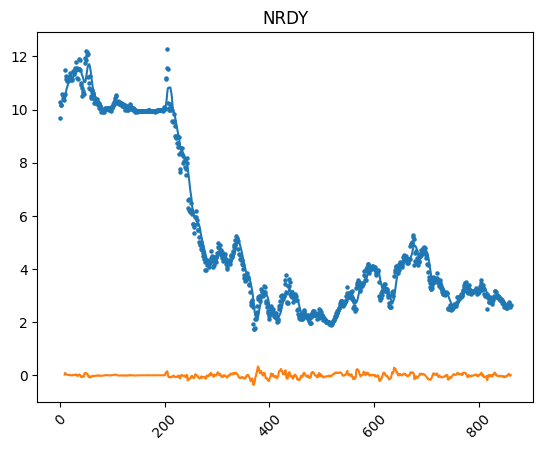

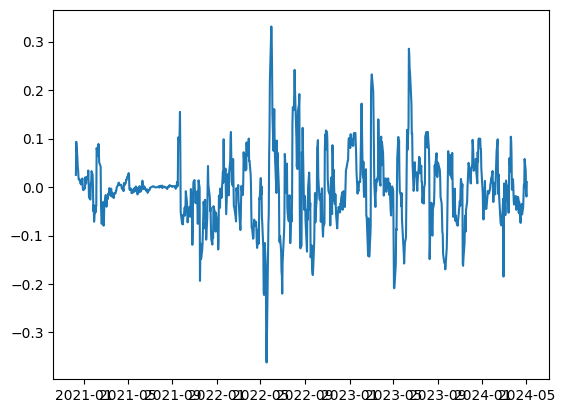

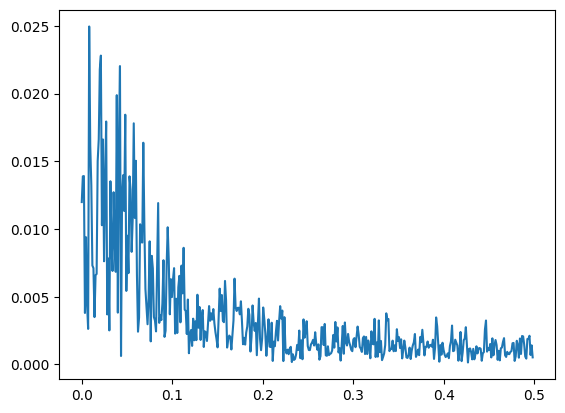

In [49]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:1]
test_tickers = test_tickers[:1]

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

DEBUG = True
detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    # .with_columns(pl.when(abs(pl.col('price')) > 1.1).then(pl.col('price')).otherwise(0).alias('price'))
)

plot_price(detrended_df)
DEBUG = True
fft_df = detrended_df.group_by('ticker').map_groups(fft)
# display(fft_df)

### Smoothing function

In [50]:
smoothing_distance = 10
sx_int = lambda x: -1 / 3 * x ** 3 + smoothing_distance ** 2 * x
A = sx_int(smoothing_distance) - sx_int(-smoothing_distance)

smoothing_function = lambda x: -1 / A * (x - smoothing_distance) * (x + smoothing_distance)

print(A)

1333.3333333333335


### Testing FFT

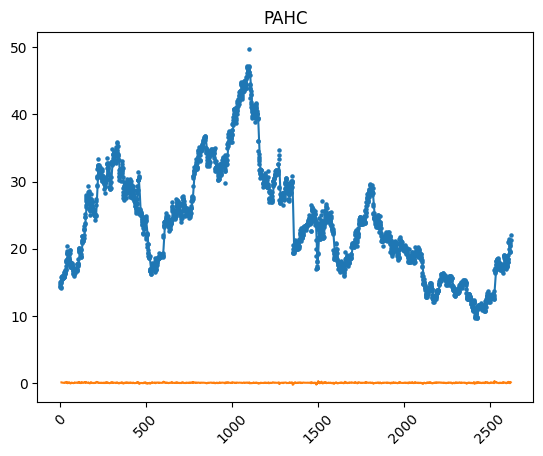

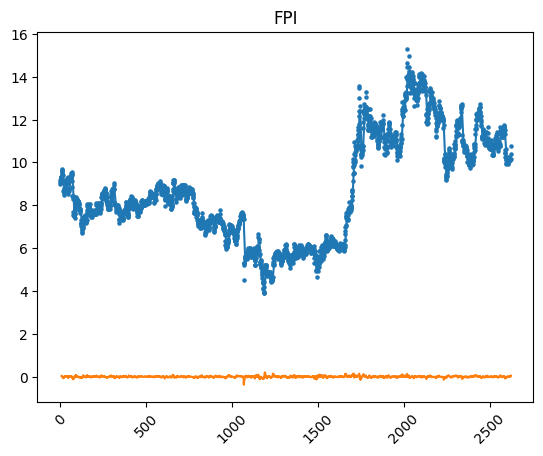

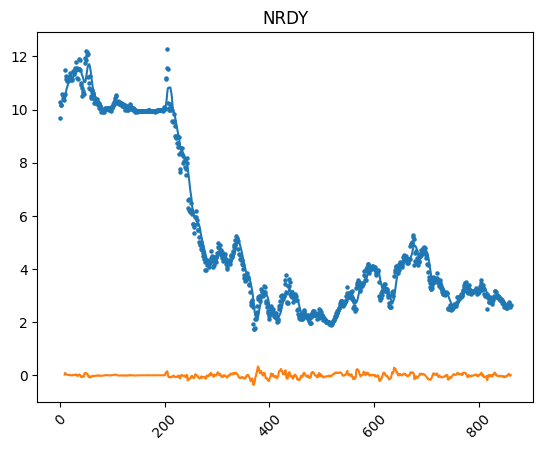

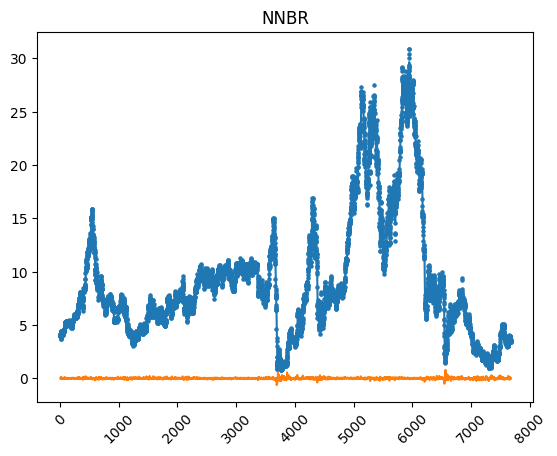

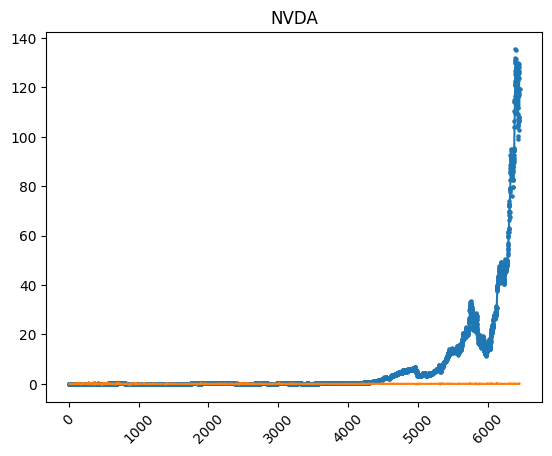

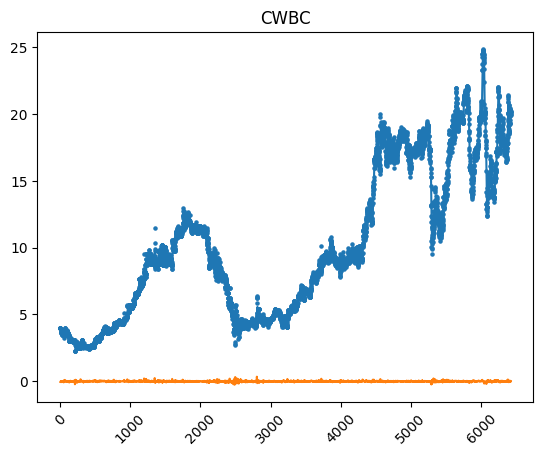

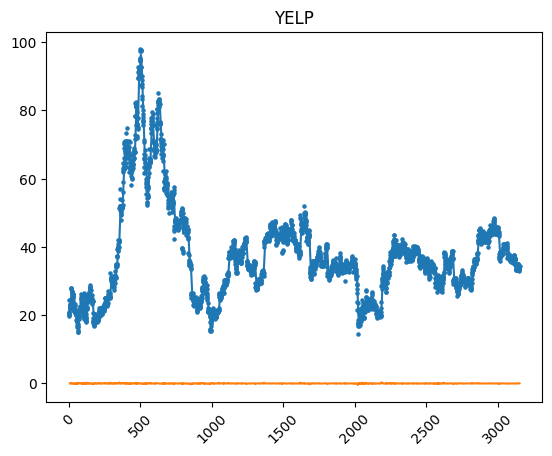

x_right,x,y
f64,f64,f64
709.83216,733.860329,-0.002153
683.801643,697.818075,-0.003835
622.730047,672.788732,-0.001016
null,238.279343,-0.003127
744.873239,807.947183,-0.000693
…,…,…
815.956573,815.956573,-2.3220e-7
365.428404,388.455399,-0.004246
401.470657,447.524648,-0.003885


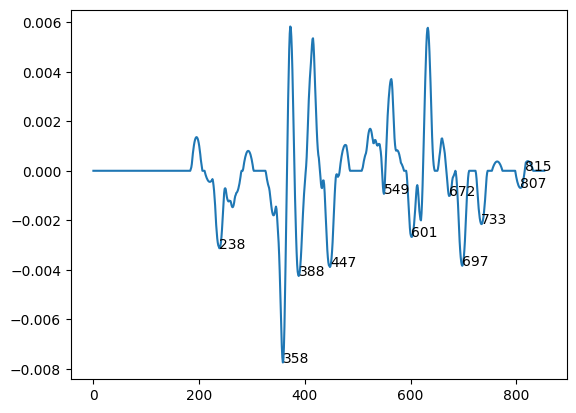

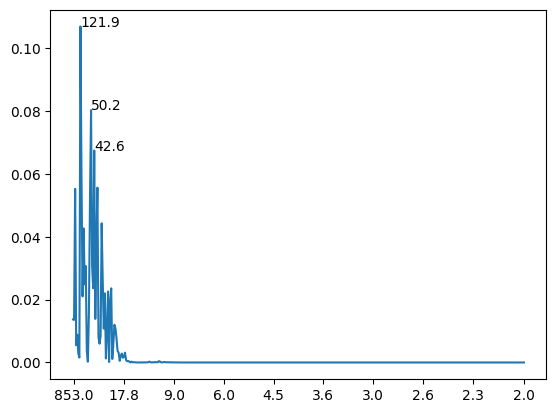

x_right,x,y
f64,f64,f64
3156.489834,3181.493714,-0.000352
3053.473848,3147.488437,-0.000508
3185.494335,4264.661804,-0.000379
null,55.008536,-0.00044
1145.177712,1168.181282,-0.001383
…,…,…
5166.8018,5308.82384,-0.002092
525.081484,616.095608,-0.000655
1002.155518,1134.176005,-0.001958


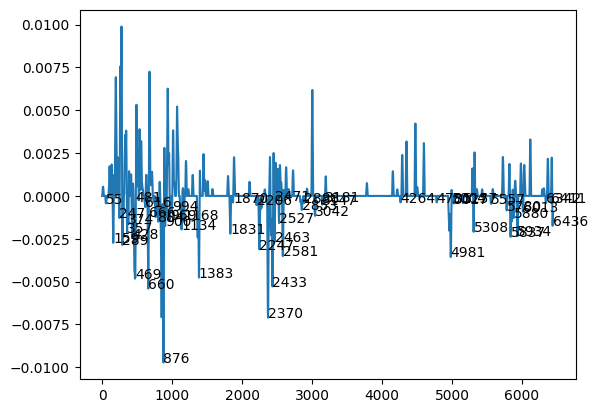

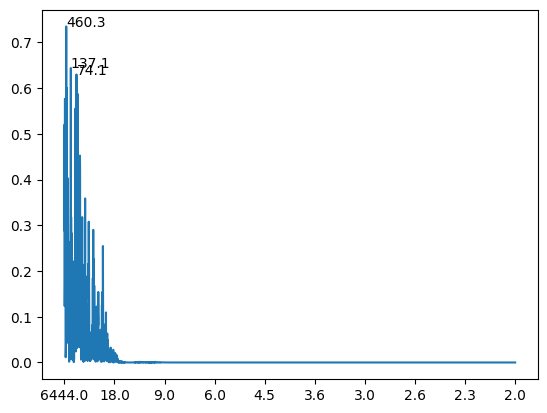

x_right,x,y
f64,f64,f64
null,359.137337,-0.000766
1489.569625,1584.605968,-0.002016
2367.905509,2404.919663,-0.001539
1156.442234,1269.485463,-0.001757
523.200077,1147.438791,-0.00081
…,…,…
2412.922724,2412.922724,-0.000197
502.192043,514.196634,-0.000396
463.177123,493.1886,-0.00041


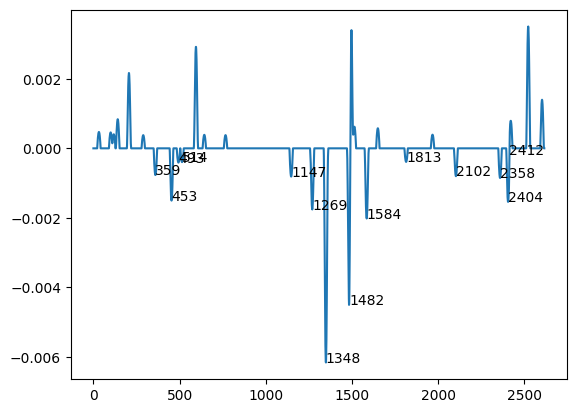

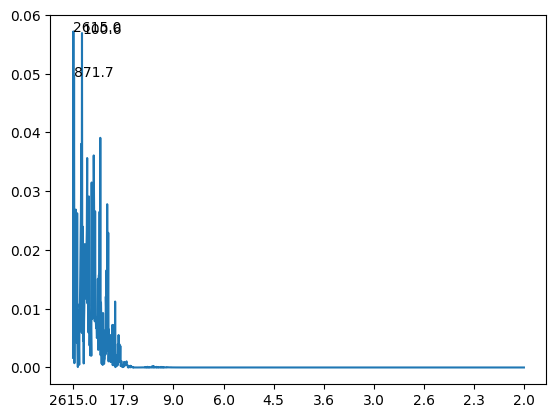

x_right,x,y
f64,f64,f64
null,0.0,-0.000742
6075.947295,6075.947295,-0.000103
2247.350382,2338.364572,-0.000377
2372.369874,2473.385623,-0.0034
241.03758,1352.210822,-0.000698
…,…,…
2513.39186,2524.393576,-0.000655
5297.825978,6035.941057,-0.001564
2347.365975,2363.36847,-0.000387


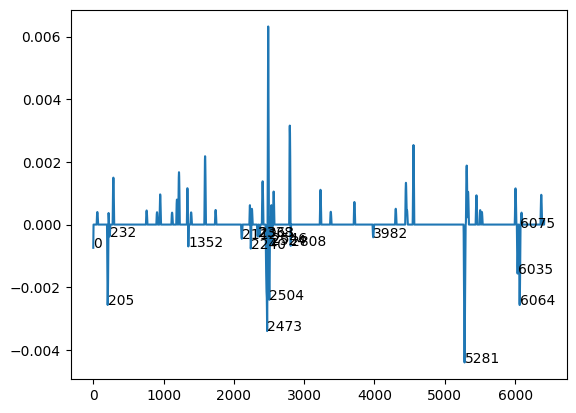

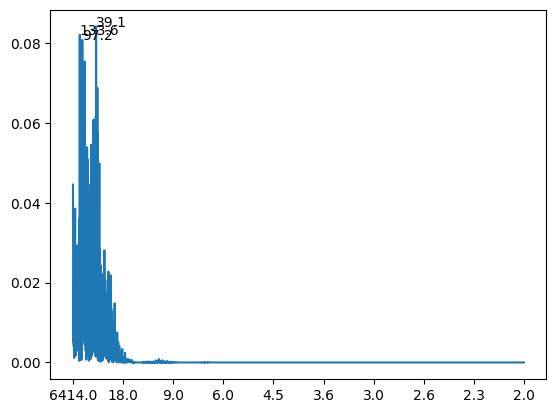

x_right,x,y
f64,f64,f64
null,68.026014,-0.000471
1173.448738,1484.567712,-0.000476
1163.444912,1171.447972,-0.000334
2234.854629,2330.891354,-0.00039
1493.571155,1741.666029,-0.002018
2339.894797,2339.894797,-0.000074
77.029457,1062.406274,-0.004346
1748.668707,2224.850803,-0.001453
1073.410482,1153.441086,-0.000876


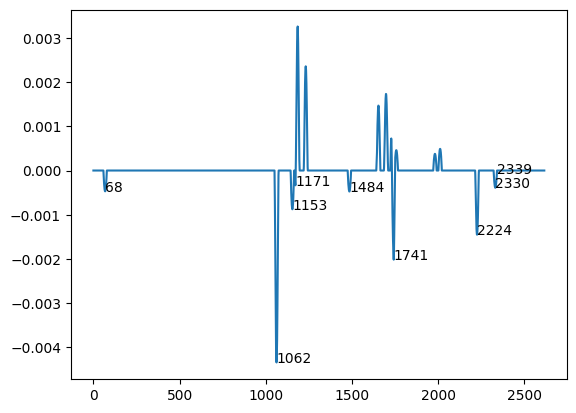

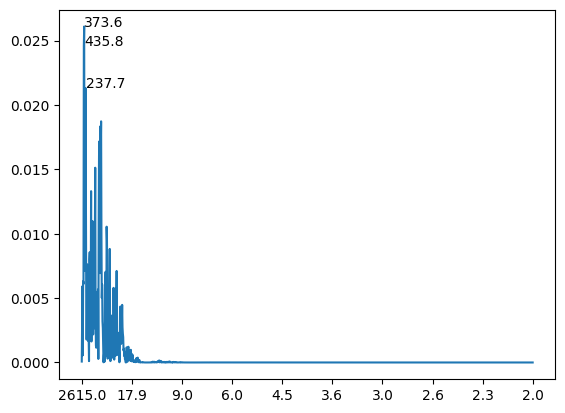

x_right,x,y
f64,f64,f64
1495.475509,1654.526081,-0.000411
null,50.015903,-0.002035
175.055662,518.164758,-0.001714
2565.81584,2680.852417,-0.002533
795.252863,849.270038,-0.004093
…,…,…
1248.396947,1298.41285,-0.002976
1812.576336,1925.612277,-0.000414
1310.416667,1485.472328,-0.000871


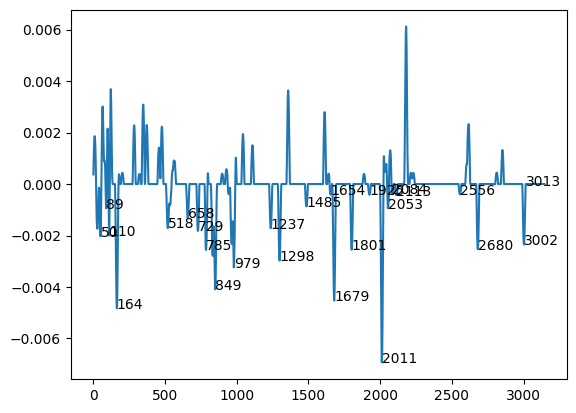

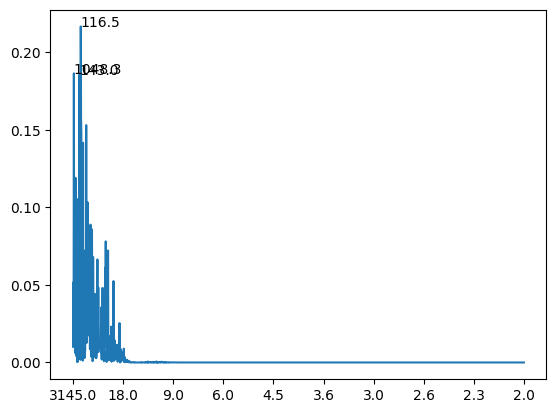

x_right,x,y
f64,f64,f64
3697.482071,3753.489373,-0.006567
3849.501891,3928.512192,-0.001027
597.077846,608.07928,-0.000415
6907.900639,6969.908723,-0.001924
2155.281001,2175.283609,-0.000826
…,…,…
7035.91733,7083.923588,-0.003114
4459.581432,4542.592255,-0.000403
7188.93728,7188.93728,-0.000402


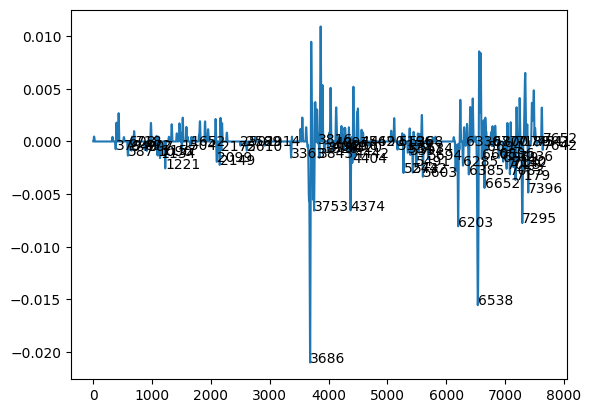

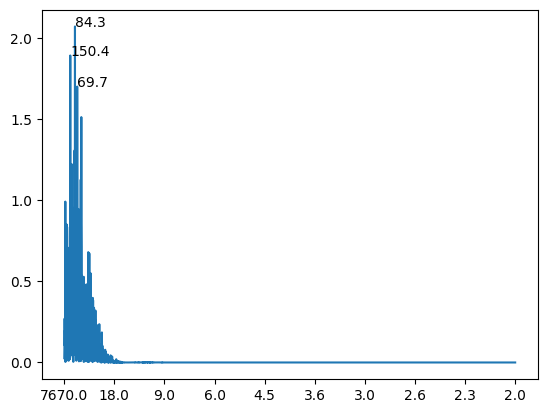

In [54]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]
# test_tickers = [test_tickers[5]]
# test_tickers = ['NRDY']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))
WINDOW_SIZE = 10
DEBUG = True

detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    .with_columns(pl.when(abs(pl.col('price')) > .1).then(pl.col('price')).otherwise(0).alias('price'))
    .with_columns(pl.mean_horizontal(
        *[pl.col('price').shift(i) * smoothing_function(i) for i in range(-smoothing_distance, smoothing_distance)]
    ).alias('price'))
)

for ticker in test_tickers:
    ticker_df = detrended_df.filter(pl.col('ticker') == pl.lit(ticker))
    

    N = ticker_df.shape[0]
    x_all = np.linspace(0, N, N)
    y_all = ticker_df['price'].to_numpy()

    overlap = 0
    windows = 1
    L = y_all.shape[-1]
    W = L // windows
    N = int(W * (1 + overlap) // 1)

    # for padding in [0, 50, 100, 500, 1000, -1000]:
    for window in range(windows):
        start = int(window * W)
        end = int(min(start + N, L) // 1)

        x = x_all[start: end]
        y = y_all[start: end]

        yf = sp.fft.fft(y)[:N//2]

        xf = sp.fft.fftfreq(N)[:N//2]

        psd = np.abs(yf) ** 2

        # plotting local minimums
        fig, ax = plt.subplots()

        plt.plot(x, y)
        min_points_df = pl.DataFrame({'x': x, 'y': y})
        first_negatives_df = min_points_df.filter((pl.col('y') < 0, pl.col('y').shift(-1) >= 0)).with_columns(pl.col('x').alias('x_right'))
        
        min_points_df = (min_points_df
            .join_asof(first_negatives_df, on='x')
            .group_by(pl.col('x_right'))
            .agg(x=pl.col('x').get(pl.col('y').arg_min()), y=pl.col('y').min())              
        )

        display(min_points_df)
        for row in min_points_df.iter_rows():
            plt.text(row[1], row[2], int(row[1]))
        # min_points = [item for item in sorted(zip(x, y), key=lambda x: x[1]) if item[1] < 0]
        # for min_point in min_points[:]:
        #     plt.text(min_point[0], min_point[1], np.round(min_point[0], 0))

        # print(min_points)
        
        plt.show()

        # fig, ax = plt.subplots()
        # plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
        # plt.show()

        fig, ax = plt.subplots()
        # plt.plot(xf, 2.0/N * np.abs(psd[0:N//2]))

        sns.lineplot(x=xf, y=psd, errorbar=None)

        xtick_indices = [int(x) for x in np.linspace(1, len(xf)-1, 10)]
        xticks = xf[xtick_indices]
        xtick_labels = np.round(([*1/xf[xtick_indices]]), 1)
        plt.xticks(xticks, xtick_labels)

        max_points = sorted(zip(xf, psd), key=lambda x: x[1], reverse=True)
        for max_point in max_points[:3]:
            plt.text(max_point[0], max_point[1], np.round(1/max_point[0], 1))
        plt.show()




In [ ]:
print(y[0], y[-1])

1.0250249474408286 1.0103329506314582
